### Imports

In [18]:
from collections import defaultdict
from datetime import datetime
from glob import glob
import json
import os
from pprint import pprint

from datasets import load_from_disk
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 500
import scipy as sp
import seaborn as sns
sns.set_style("white")
from tqdm.notebook import tqdm

### Helpful functions, variables

In [19]:
def compress_binary_array(arr):
    """ compress binary array (e.g., array of incorrect / correct labels) by
        converting consecutive subsequences of 0s / 1s into single 0 / 1 """
    return arr if arr.size == 0 else arr[np.insert(np.diff(arr) != 0, 0, True)]


def key(fname):
    """ key for sorting results files based on checkpoints step """
    dirname = os.path.basename(os.path.dirname(fname))
    for part in dirname.split("-"):
        if "step" in part:
            return int(part.replace("step", ""))
    raise RuntimeError("'step' not found in dirname")

# ParaRel relations, filename pattern for OLMo prediction results
relations = ["p17", "p27", "p36", "p127", "p131", "p138", "p176",
             "p178", "p276", "p495", "p1376", "p1412"]

# index of main template for each relation
template_index = {
    "p17": 0,
    "p27": 2,
    "p36": 0,
    "p127": 0,
    "p131": 0,
    "p138": 1,
    "p176": 0,
    "p178": 0,
    "p276": 1,
    "p279": 0,
    "p495": 2,
    "p1376": 0,
    "p1412": 0
}

# majority label baseline for each relation
majority_baseline = {
    "p17":   79. / 928,
    "p27":   97. / 966,
    "p36":   10. / 681,
    "p127":  63. / 687,
    "p131":  30. / 881,
    "p138":  11. / 604,
    "p176":  100. / 961,
    "p178":  164. / 580,
    "p276":  44. / 877,
    "p495":  128. / 907,
    "p1376": 4. / 216,
    "p1412": 234. / 965,
}

### Get correctness labels for all instances across all relations

In [20]:
labels = np.load(f"{os.environ['HOME']}/projects/pretrain-intervention/results/eval/"
                 "labels_olmo2_7b_step_1k_to_30k_pararel_12rel.npz")

print("labels shapes:")
pprint({k : v.shape for k, v in labels.items()})

correct_labels = labels["labels"]
relation_labels = labels["dataset_labels"]
ckpt_steps = labels["steps"]

# load labels for step 2150, insert into correctness labels and steps
labels = np.load(f"{os.environ['HOME']}/projects/pretrain-intervention/results/eval/"
                 "labels_olmo2_7b_step_2150_retr_pararel_12rel.npz")
correct_labels = np.hstack((correct_labels[:, :2], labels["labels"], correct_labels[:, 2:]))
ckpt_steps = np.concatenate((ckpt_steps[:2], [2150], ckpt_steps[2:]))

# get per-relation accuracies from correctness labels
accuracies = dict()
for rel in relations:
    idxs = np.where(relation_labels == rel)[0]
    accuracies[rel] = np.mean(correct_labels[idxs, :], axis=0)

# print shapes
print("correct_labels.shape:", correct_labels.shape)
print("accuracies shapes:")
pprint({k : v.shape for k, v in accuracies.items()})
print("ckpt_steps:", ckpt_steps)

labels shapes:
{'dataset_labels': (9253,), 'labels': (9253, 30), 'steps': (30,)}
correct_labels.shape: (9253, 31)
accuracies shapes:
{'p127': (31,),
 'p131': (31,),
 'p1376': (31,),
 'p138': (31,),
 'p1412': (31,),
 'p17': (31,),
 'p176': (31,),
 'p178': (31,),
 'p27': (31,),
 'p276': (31,),
 'p36': (31,),
 'p495': (31,)}
ckpt_steps: [ 1000  2000  2150  3000  4000  5000  6000  7000  8000  9000 10000 11000
 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000
 24000 25000 26000 27000 28000 29000 30000]


### Plot performance of OLMo-2-1124-7B on all ParaRel relations

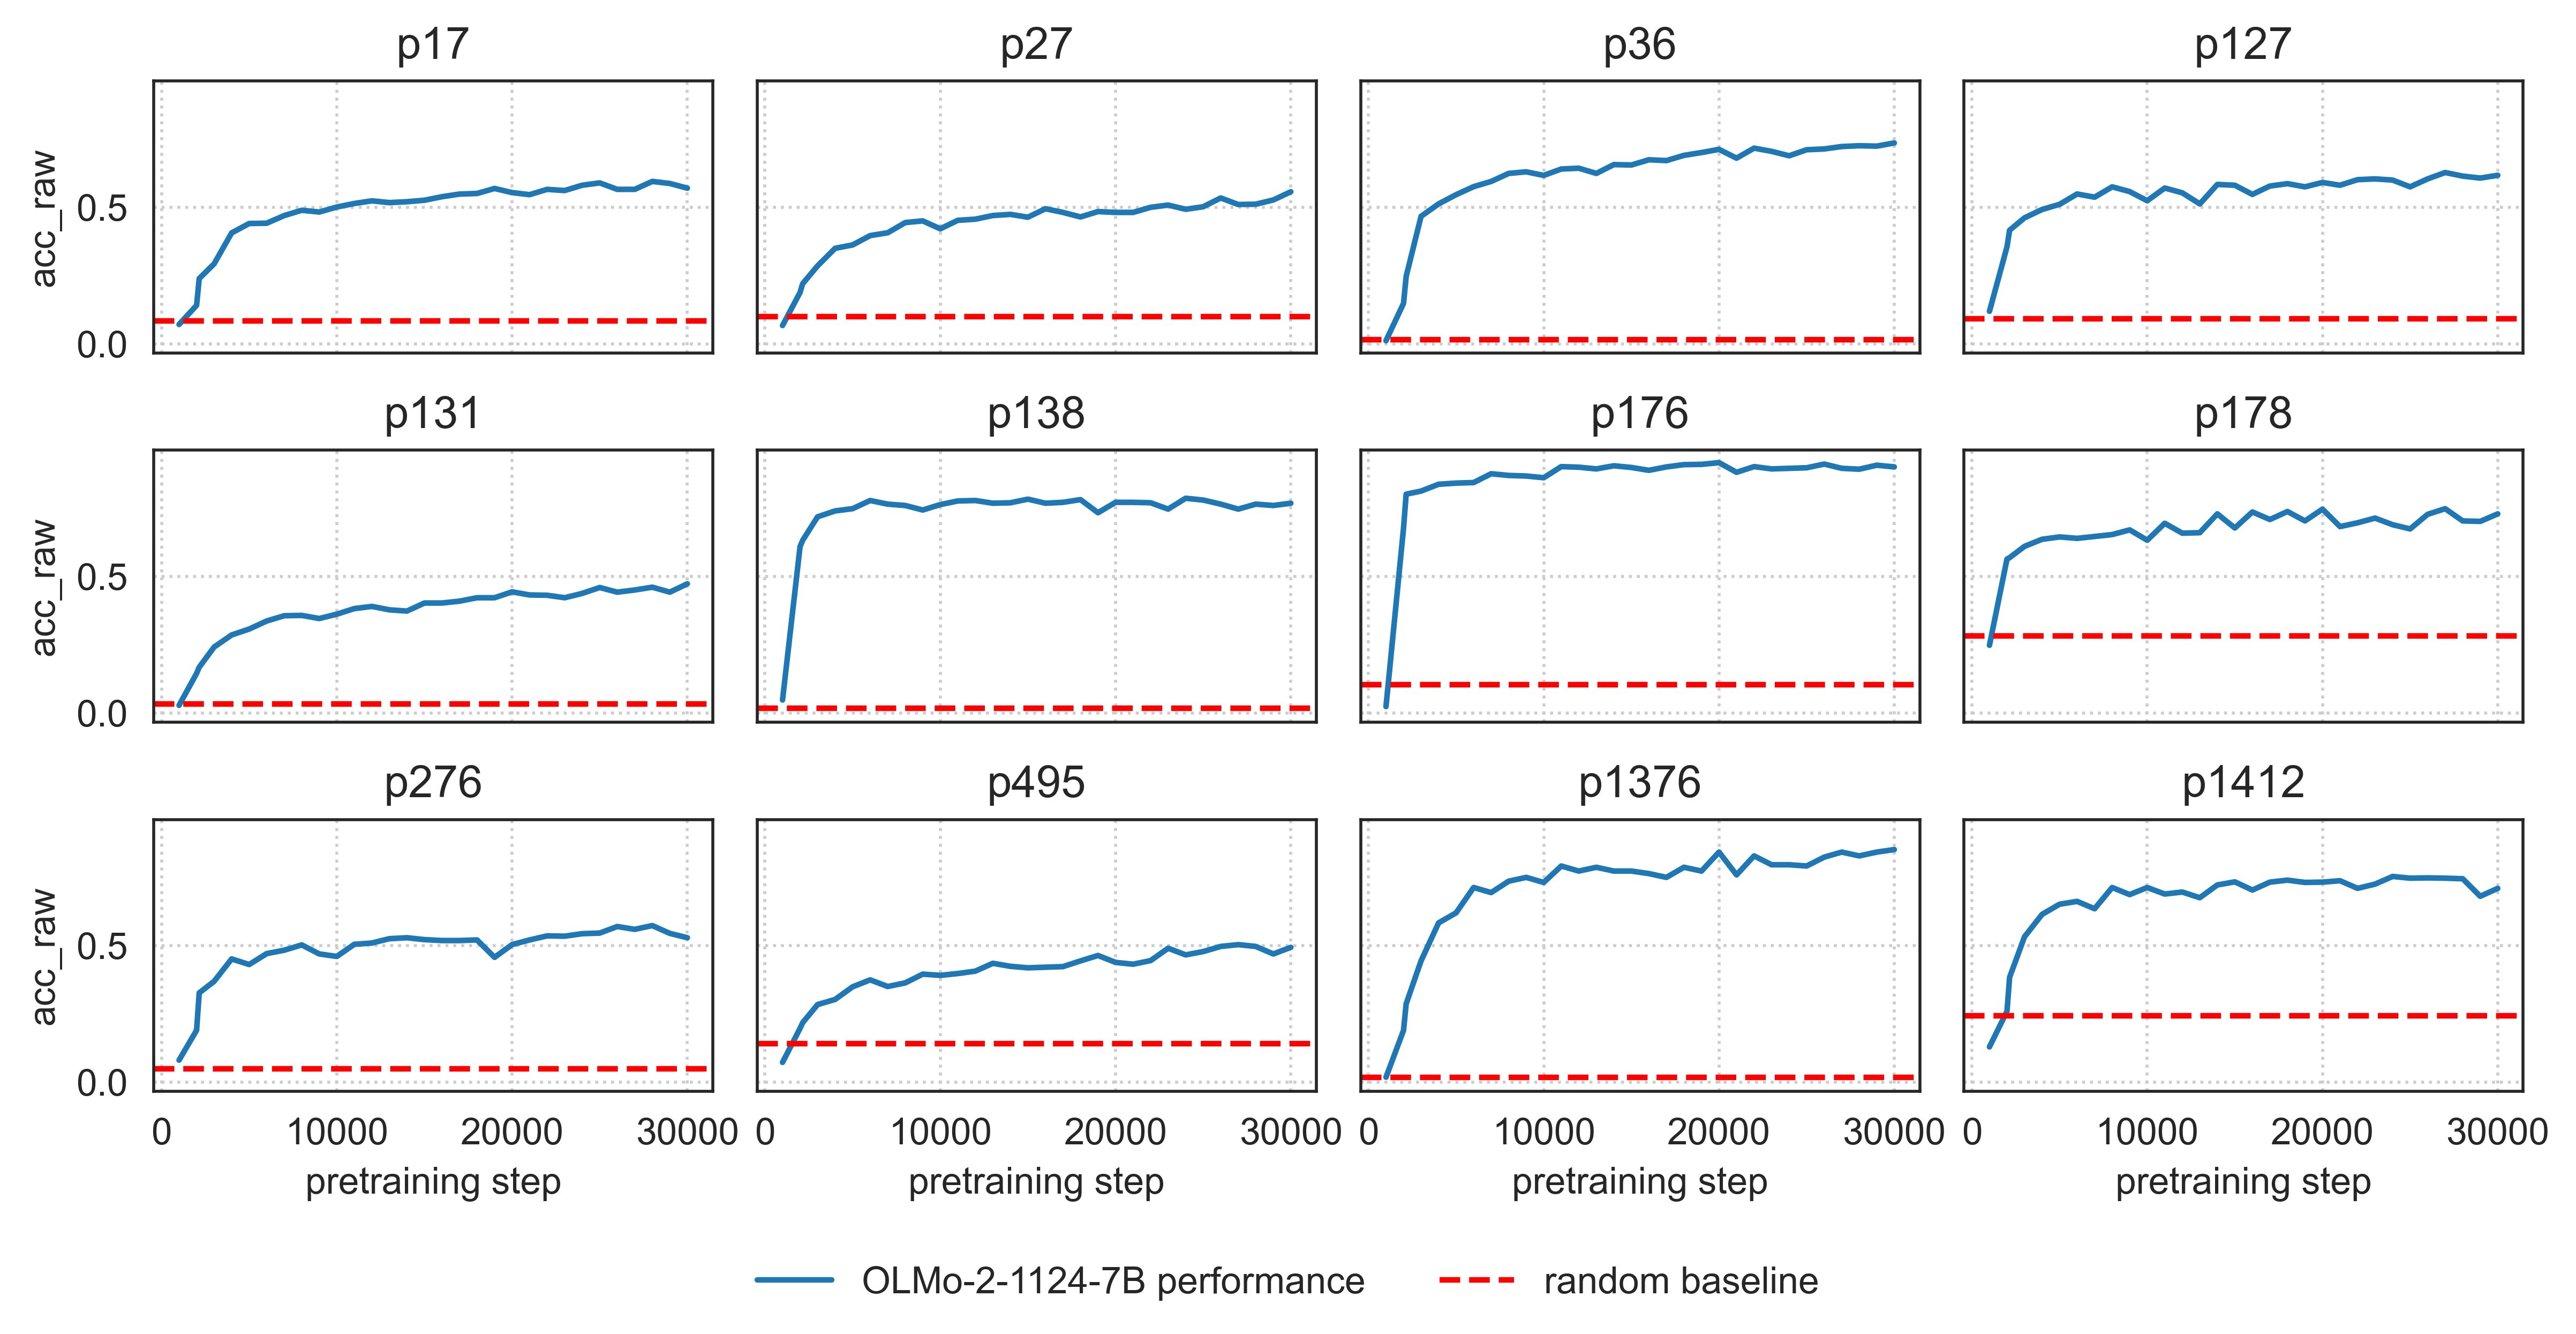

In [21]:
fig, ax = plt.subplots(3, 4, sharex=True, sharey=True,
                       figsize=(9.7, 5))

for i, rel in enumerate(relations):
    r, c = np.unravel_index(i, ax.shape)
    ax[r, c].plot(ckpt_steps, accuracies[rel], label="OLMo-2-1124-7B performance")
    ax[r, c].axhline(majority_baseline[rel], linestyle="dashed", color="red",
                     label="random baseline")
    ax[r, c].grid(linestyle="dotted")
    if r == ax.shape[0] - 1:
        ax[r, c].set_xlabel("pretraining step")
    if c == 0:
        ax[r, c].set_ylabel("acc_raw")
    ax[r, c].set_title(rel)

fig.legend(handles=ax[0, 0].lines, loc="lower center", ncol=2, frameon=False)
plt.tight_layout()
plt.subplots_adjust(bottom=0.175)
plt.show()

### Get sparse matrices of {term pair, document} occurrences, stack across relations

In [22]:
term_pair_doc_pattern = (f"{os.environ['HOME']}/projects/pretrain-intervention/results/olmo-mix-1124-7b/"
                         "term_pair_doc_matrices/pararel_patterns_{rel}/{ckpt}.npz")

# get {term pair, doc} matrices, relation labels
pair_doc_matxs = dict()
relation_labels_ = list()
for i in range(1, 4):
    matrices = list()
    for rel_idx, rel in enumerate(relations):
        matrix = sp.sparse.load_npz(term_pair_doc_pattern.format(rel=rel, ckpt=f"{i:03d}"))
        matrices.append(matrix)
        if i == 1:
            relation_labels_.extend([rel] * matrix.shape[0])
    pair_doc_matxs[1000 * i] = sp.sparse.vstack(matrices)
relation_labels_ = np.array(relation_labels)
assert np.all(relation_labels == relation_labels_), "relation labels do not match"

# split matrix at step 3000 into occurrences from 2000 to 2150, 2150 to 3000
info = np.load(os.path.join(os.environ["HOME"], "projects", "pretrain-intervention", "results",
                            "olmo-mix-1124-7b", "doc_info", "allenai-OLMo-2-1124-7B",
                            "003.npy"))
idx = np.where(info[:, 0] == 150)[0][0]
tmp = pair_doc_matxs[3000]
pair_doc_matxs[2150] = tmp[:, :idx]
pair_doc_matxs[3000] = tmp[:, idx:]
print("pair_doc_matxs shapes:")
pprint({k : v.shape for k, v in pair_doc_matxs.items()})

# get co-occurrence counts (sum across columns of {term pair, doc} matrices)
coocc_counts = list()
for step in [1000, 2000, 2150, 3000]:
    coocc_counts.append(np.sum(pair_doc_matxs[step], axis=1).A1.flatten())
coocc_counts = np.vstack(coocc_counts).T
print("coocc_counts.shape:", coocc_counts.shape)

pair_doc_matxs shapes:
{1000: (9253, 4359936),
 2000: (9253, 4359128),
 2150: (9253, 653619),
 3000: (9253, 3700977)}
coocc_counts.shape: (9253, 4)


### Get sparse matrices of term-document occurrences for all relations

In [23]:
term_doc_pattern = (f"{os.environ['HOME']}/projects/pretrain-intervention/results/olmo-mix-1124-7b/"
                    "term_doc_matrices/pararel_patterns_{rel}/{ckpt}.npz")

# get term-doc matrices
term_doc_matxs = defaultdict(dict)
for i in range(1, 4):
    ckpt = f"{i:03d}"
    matrices = list()
    for rel_idx, rel in enumerate(relations):
        term_doc_matxs[1000 * i][rel] = sp.sparse.load_npz(term_doc_pattern.format(rel=rel, ckpt=ckpt))

# split matrix at step 3000 into occurrences from 2000 to 2150, 2150 to 3000
info = np.load(os.path.join(os.environ["HOME"], "projects", "pretrain-intervention", "results",
                            "olmo-mix-1124-7b", "doc_info", "allenai-OLMo-2-1124-7B",
                            "003.npy"))
idx = np.where(info[:, 0] == 150)[0][0]
for rel in relations:
    tmp = term_doc_matxs[3000][rel]
    term_doc_matxs[2150][rel] = tmp[:, :idx]
    term_doc_matxs[3000][rel] = tmp[:, idx:]

### Get term list indices of entities for each instance, for each relation

In [24]:
# path to Huggingface format dataset for relation
dataset_pattern = (f"{os.environ['HOME']}/projects/pretrain-intervention/data/"
                   "huggingface/pararel_patterns_{rel}")

# path to text file with list of terms for relation
terms_file_pattern = (f"{os.environ['HOME']}/projects/pretrain-intervention/data/"
                      "search_terms/pararel_patterns_{rel}_train.txt")

term_idxs = dict()
for rel in tqdm(relations):
    dataset = load_from_disk(dataset_pattern.format(rel=rel))
    pairs = list(zip(list(map(str.strip, dataset["train"]["subject"])),
                     list(map(str.strip, dataset["train"]["object"]))))
    with open(terms_file_pattern.format(rel=rel), "r") as f:
        terms = list(map(str.strip, f.readlines()))
    term_idxs[rel] = [(terms.index(subj), terms.index(obj))
                      for subj, obj in pairs]

  0%|          | 0/12 [00:00<?, ?it/s]

### Get histogram of learned checkpoints across all relations

For each relation, find the instances that are "definitively learned", i.e., there exists a checkpoint where that instance is always incorrect before and always correct after (their correctness label is a step function). For these instances, keep counts of at which checkpoints they're learned for all relations.

In [25]:
learned_ckpts_all = list()
learned_idxs_all = list()

# get learned checkpoint for instances that are definitively learned
# (only incorrect up to a checkpoint, then only correct after)
for i, row in enumerate(correct_labels):
    compressed = compress_binary_array(row)
    if len(compressed) == 2 and np.allclose(compressed, [0, 1]) or \
        len(compressed) == 1 and np.allclose(compressed, [1]):
        learned_ckpts_all.append(np.where(row == 1)[0][0])
        learned_idxs_all.append(i)

learned_ckpts_all = np.array(learned_ckpts_all)
learned_idxs_all = np.array(learned_idxs_all)

# restrict to those learned before step 3000
idx_limit = 4
idxs = np.where(learned_ckpts_all < idx_limit)[0]
learned_ckpts = learned_ckpts_all[idxs]
learned_idxs = learned_idxs_all[idxs]

binned_learned_ckpts = np.bincount(learned_ckpts, minlength=idx_limit)

print("learned_ckpts.shape:", learned_ckpts.shape)
print("learned_idxs.shape:", learned_idxs.shape)
print("binned_learned_ckpts.shape:", binned_learned_ckpts.shape)

# for each learned checkpoint, get the number of learned instances that
# have non-zero co-occurrence in the previous checkpoint
learned_nonzero_counts = np.zeros_like(binned_learned_ckpts)
learned_nonzero_count_idxs = list()
for i in range(len(binned_learned_ckpts)):
    idxs = np.where(learned_ckpts == i)[0]
    nonzero_idxs = np.nonzero(coocc_counts[learned_idxs[idxs], i])[0]
    learned_nonzero_counts[i] = len(nonzero_idxs)
    learned_nonzero_count_idxs.append(learned_idxs[idxs][nonzero_idxs])
    assert np.all(coocc_counts[learned_nonzero_count_idxs[-1], i] > 0)
    assert np.all(np.isin(learned_nonzero_count_idxs[-1], learned_idxs))

learned_ckpts.shape: (2971,)
learned_idxs.shape: (2971,)
binned_learned_ckpts.shape: (4,)


### Plot histogram of learned checkpoints across all relations (first 30k steps)

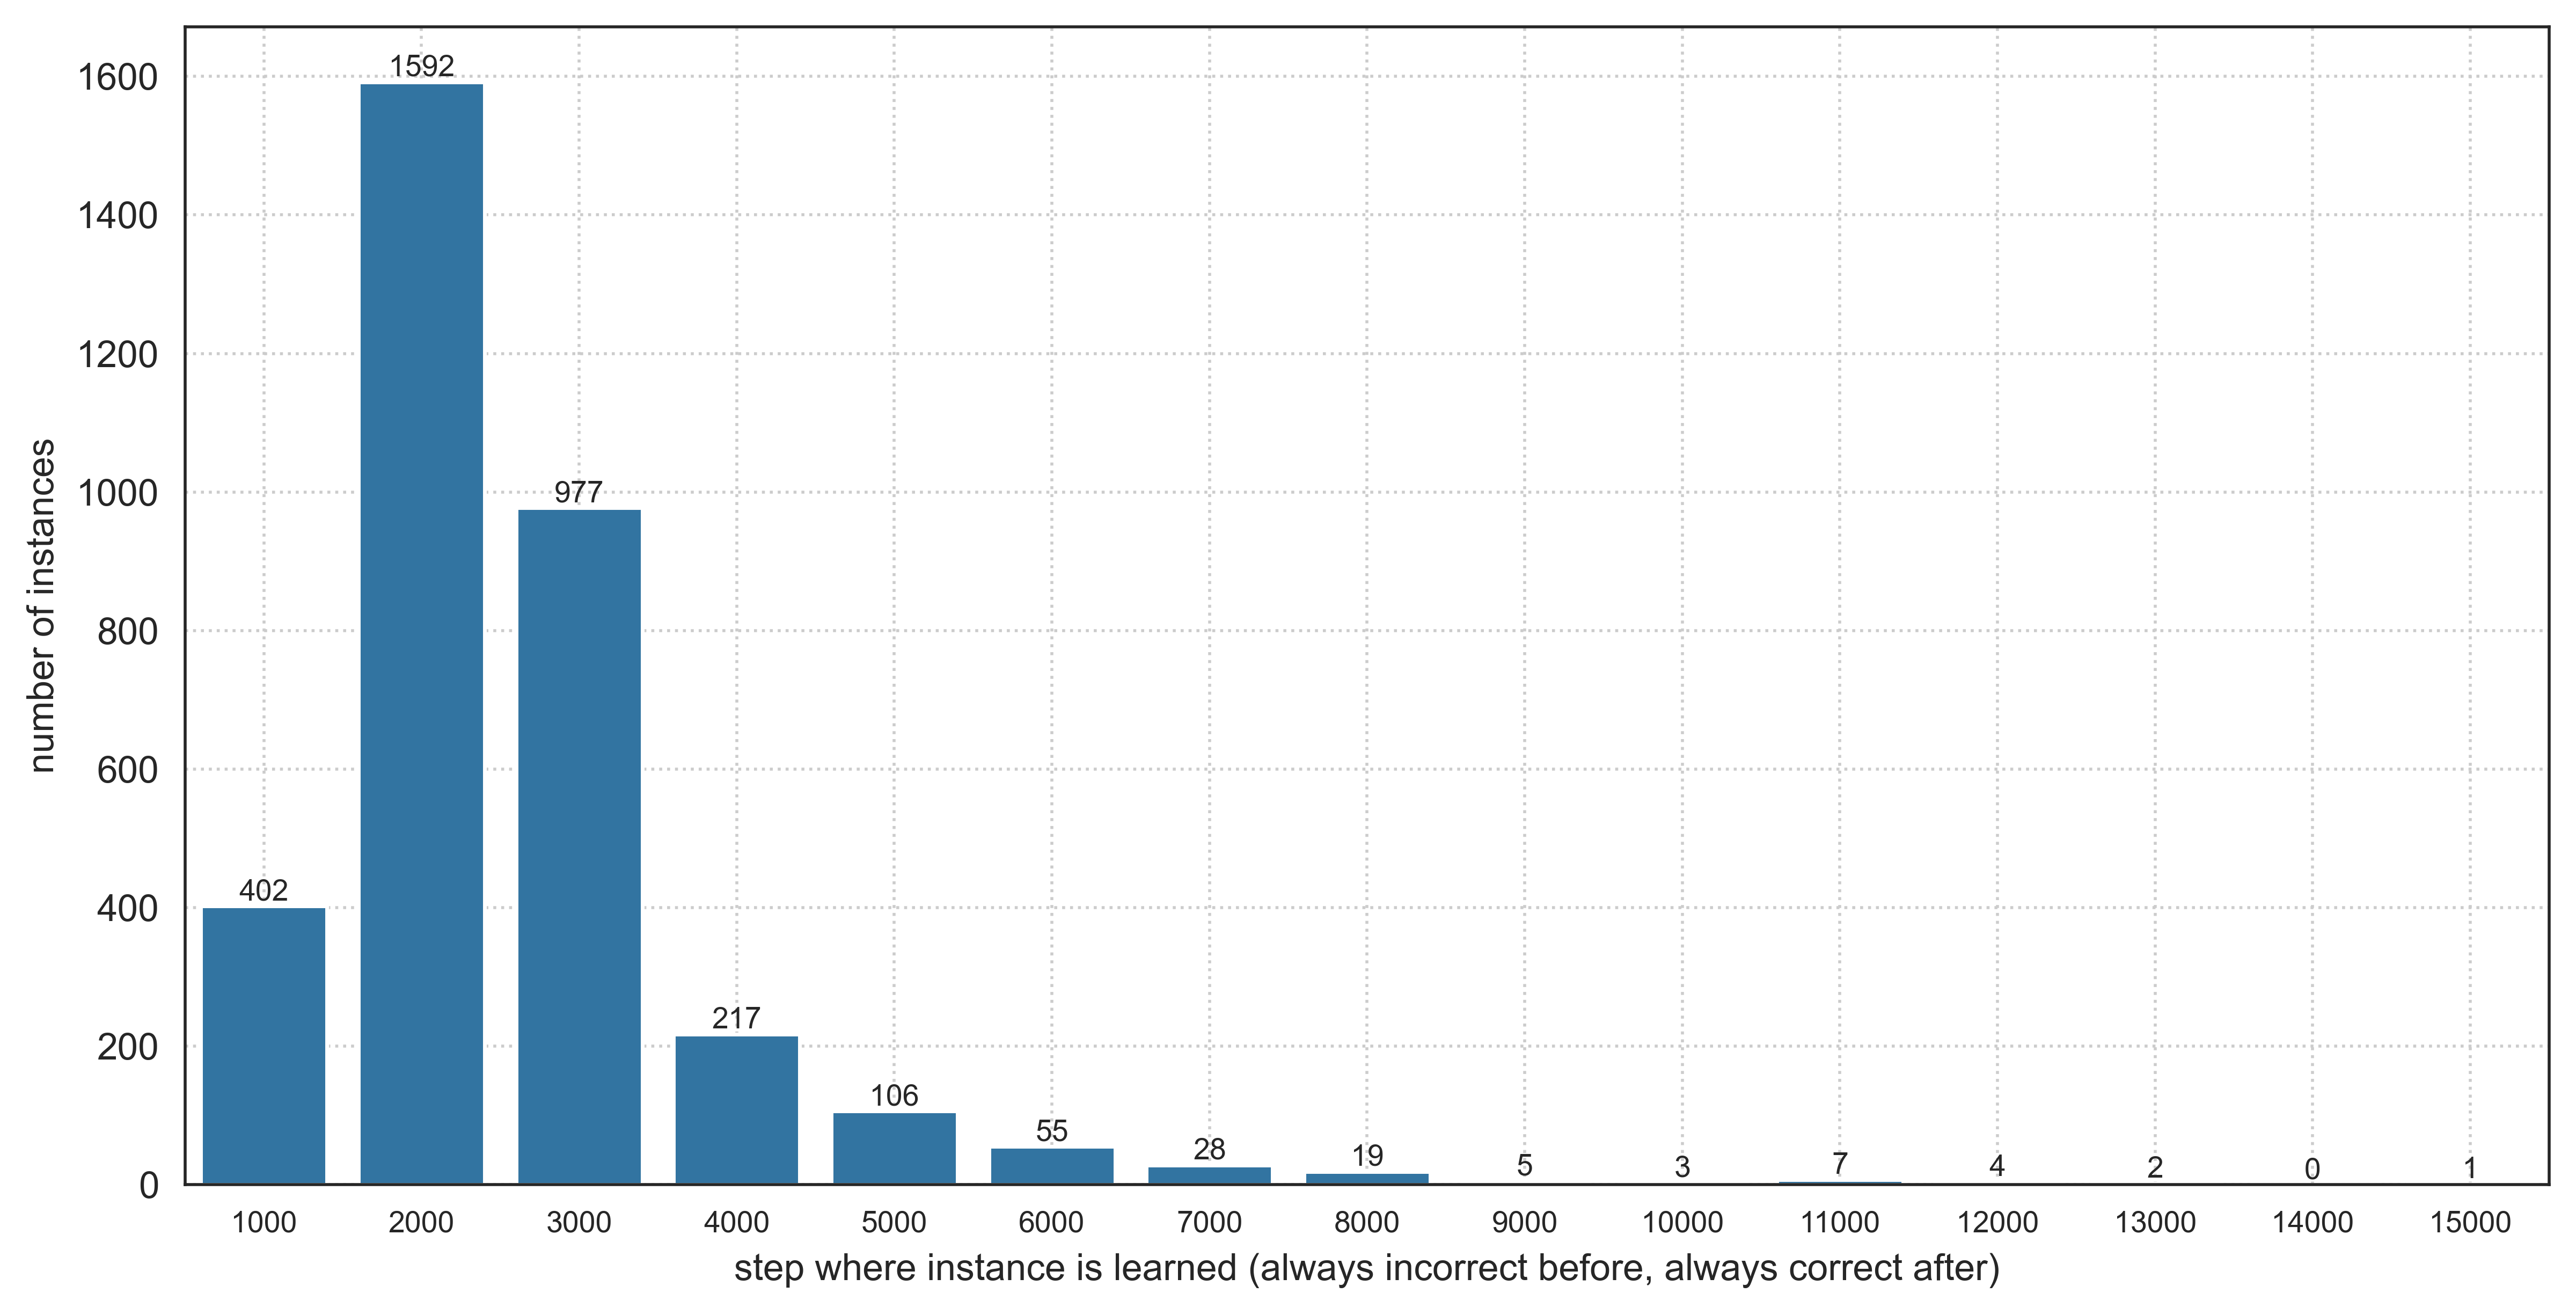

In [26]:
# collapse counts at step 2150 into step 3000
learned_ckpts_all[learned_ckpts_all == 3] = 2
learned_ckpts_all[learned_ckpts_all > 3] = learned_ckpts_all[learned_ckpts_all > 3] - 1
learned_ckpts_all = learned_ckpts_all[learned_ckpts_all < 15]
counts = np.bincount(learned_ckpts_all)

fig = plt.figure(figsize=(9.7, 5))
ax = sns.barplot(x=1000 * np.arange(1, len(counts) + 1),
                 y=counts,
                 color="tab:blue",
                 label="# learned at this checkpoint")
ax.bar_label(ax.containers[0], fontsize=8)
plt.legend().set_visible(False)
plt.xticks(np.arange(len(counts)),
           1000 * (np.arange(len(counts)) + 1),
           fontsize=8)
plt.grid(linestyle="dotted")
plt.xlabel("step where instance is learned (always incorrect before, "
           "always correct after)")
plt.ylabel("number of instances")
plt.tight_layout()
plt.show()

### Plot histogram of learned checkpoints across all relations (first 3000 steps)

[ 402 1592  559  418]
[ 334 1158  272  300]


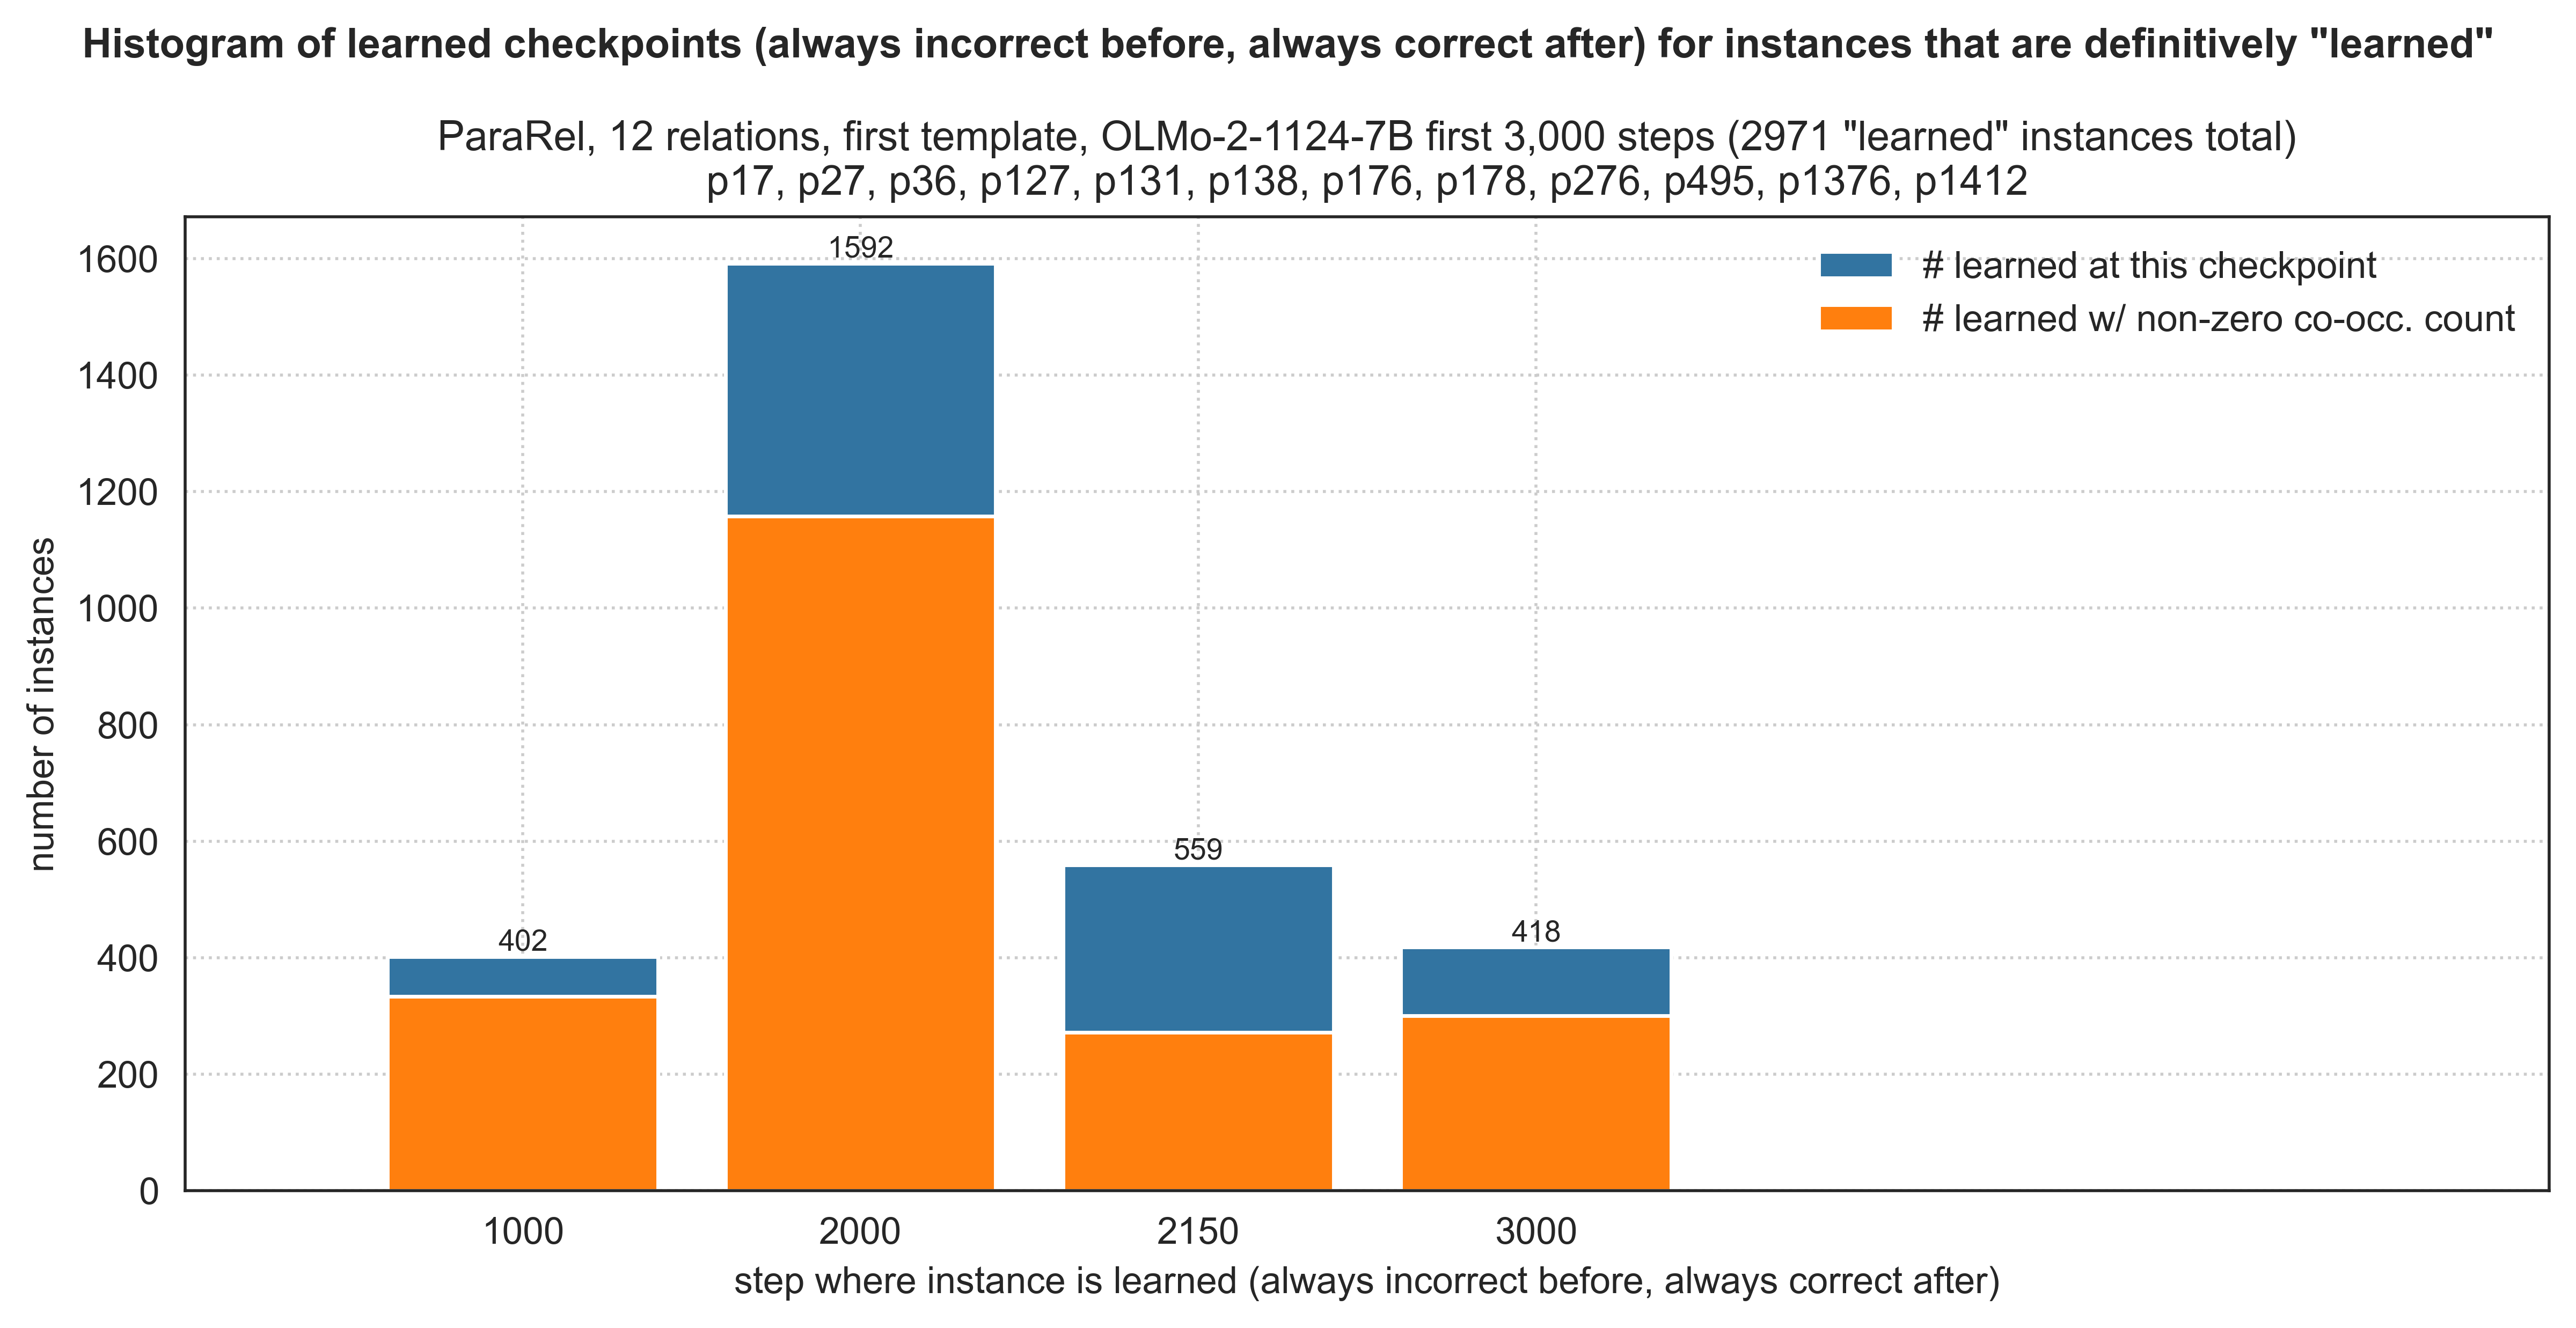

In [27]:
plt.figure(figsize=(9.7, 5))

print(binned_learned_ckpts)
print(learned_nonzero_counts)

# plot learned checkpoint histogram, label bars
ax = sns.barplot(x=ckpt_steps[:len(binned_learned_ckpts)],
                 y=binned_learned_ckpts,
                 color="tab:blue",
                 label="# learned at this checkpoint")
ax.bar_label(ax.containers[0], fontsize=8)
plt.bar(np.arange(len(binned_learned_ckpts)),
        learned_nonzero_counts,
        color="tab:orange",
        label="# learned w/ non-zero co-occ. count")

# add axis grid, label axes
plt.grid(linestyle="dotted")
plt.xlabel("step where instance is learned (always incorrect before, "
           "always correct after)")
plt.xticks(np.arange(len(binned_learned_ckpts)), ckpt_steps[:len(binned_learned_ckpts)])
plt.xlim(-1, 6)
plt.ylabel("number of instances")
# plt.yticks(np.arange(0, 651, 50))

# add titles, save figure to file
plt.suptitle("Histogram of learned checkpoints (always incorrect before, "
             "always correct after) for instances that are definitively "
             "\"learned\"", fontweight="bold", fontsize=11)
total_count = np.sum(binned_learned_ckpts)
relations_str = ", ".join(relations)
plt.title(f"ParaRel, {len(relations)} relations, first template, OLMo-2-1124-7B first "
          f"3,000 steps ({total_count} \"learned\" instances total)\n{relations_str}",
          fontsize=11)
plt.legend(loc="upper right", ncol=1, frameon=False)
plt.tight_layout()
plt.show()

### Get indices of documents to swap based on ***removing co-occurrences***

In [28]:
curr_step, next_step = 2150, 3000
curr_idx, next_idx = 2, 3

# load doc info for steps 2150 and 3000, get doc lengths
doc_info = np.load(os.path.join(os.environ["HOME"], "projects", "pretrain-intervention",
                                "results", "olmo-mix-1124-7b", "doc_info", "allenai-OLMo-2-1124-7B",
                                f"{int(next_step / 1000):03d}.npy"))
next_start_idx = np.where(doc_info[:, 0] == 150)[0][0]
print(next_start_idx)
doc_info_curr = doc_info[:next_start_idx, :]
doc_lengths_curr = doc_info_curr[:, -1] - doc_info_curr[:, -2] + 1
doc_info_next = doc_info[next_start_idx:, :]
doc_lengths_next = doc_info_next[:, -1] - doc_info_next[:, -2] + 1

assert doc_info_curr.shape[0] == pair_doc_matxs[curr_step].shape[1], curr_step
assert doc_info_next.shape[0] == pair_doc_matxs[next_step].shape[1], next_step

# get instances learned in curr ckpt
inst_idxs_curr = learned_nonzero_count_idxs[curr_idx]

# get indices of documents that match instances learned in curr ckpt
doc_idxs_curr = np.nonzero(
    np.sign(
        np.sum(
            pair_doc_matxs[curr_step][inst_idxs_curr, :],
        axis=0).A1.flatten()
    )
)[0]
print(f"num instances, {curr_step}:", len(inst_idxs_curr))
print(f"num docs, {curr_step}:", len(doc_idxs_curr))
print()

# get instances learned in next ckpt
inst_idxs_next = learned_nonzero_count_idxs[next_idx]

# get indices of documents that match instances learned in next ckpt
doc_idxs_next = np.nonzero(
    np.sign(
        np.sum(
            pair_doc_matxs[next_step][inst_idxs_next, :],
        axis=0).A1.flatten()
    )
)[0]
print(f"num instances, {next_step}:", len(inst_idxs_next))
print(f"num docs, {next_step}:", len(doc_idxs_next))
print()

# get indices of documents in next ckpt that match instances learned in curr ckpt
doc_idxs_curr_in_next = np.nonzero(
    np.sign(
        np.sum(
            pair_doc_matxs[next_step][inst_idxs_curr, :],
        axis=0).A1.flatten()
    )
)[0]
print(f"num docs, {curr_step} in {next_step}:", len(doc_idxs_curr_in_next))
print(f"num docs overlap, {curr_step} in {next_step}:", len(set(doc_idxs_curr_in_next) & set(doc_idxs_next)))
print()

# get extra doc indices (documents in next ckpt that don't match instances
# learned in either curr ckpt or next ckpt)
num_docs_next = pair_doc_matxs[next_step].shape[1]
extra_doc_idxs = sorted(set(list(range(num_docs_next))) -
                        (set(doc_idxs_next) | set(doc_idxs_curr_in_next)))
print(f"num docs {next_step}, total:", pair_doc_matxs[next_step].shape[1])
print(f"num docs {next_step}, extra:", len(extra_doc_idxs))
print()

# add offset to extra doc IDs, since they're actually coming from same batch
extra_doc_idxs = np.array(extra_doc_idxs) + next_start_idx

# construct indices dictionary
coocc_indices = dict(
    orig_idxs=doc_idxs_curr,
    orig_inst_idxs=inst_idxs_curr,
    new_idxs=np.array([]),
    new_inst_idxs=np.array([]),
    extra_idxs=extra_doc_idxs,
    relations=relations,
    relation_labels=relation_labels,
    template_idxs=np.array([template_index[rel] for rel in relations]),
)

# save set of original doc indices from curr ckpt, new doc indices from
# next ckpt, and extra doc indices from next ckpt
resdir = os.path.join(os.environ["HOME"], "projects", "pretrain-intervention", "data", "swap_indices")
os.makedirs(resdir, exist_ok=True)
np.savez(os.path.join(resdir, f"doc_idxs_olmo_mix_1124_7b_pararel_12rel_swap_{curr_step}_{next_step}_rm_coocc.npz"),
         **coocc_indices)

653619
num instances, 2150: 272
num docs, 2150: 15933

num instances, 3000: 300
num docs, 3000: 58727

num docs, 2150 in 3000: 89658
num docs overlap, 2150 in 3000: 13862

num docs 3000, total: 3700977
num docs 3000, extra: 3566454



### Get indices of documents to swap based on ***removing occurrences***

In [29]:
curr_step, next_step = 2150, 3000
curr_idx, next_idx = 2, 3

# load doc info for steps 2150 and 3000, get doc lengths
doc_info = np.load(os.path.join(os.environ["HOME"], "projects", "pretrain-intervention",
                                "results", "olmo-mix-1124-7b", "doc_info", "allenai-OLMo-2-1124-7B",
                                f"{int(next_step / 1000):03d}.npy"))
next_start_idx = np.where(doc_info[:, 0] == 150)[0][0]
print(next_start_idx)
doc_info_curr = doc_info[:next_start_idx, :]
doc_lengths_curr = doc_info_curr[:, -1] - doc_info_curr[:, -2] + 1
doc_info_next = doc_info[next_start_idx:, :]
doc_lengths_next = doc_info_next[:, -1] - doc_info_next[:, -2] + 1

assert doc_info_curr.shape[0] == pair_doc_matxs[curr_step].shape[1], curr_step
assert doc_info_next.shape[0] == pair_doc_matxs[next_step].shape[1], next_step

# get indices of instances learned in current checkpoint
inst_idxs_curr = learned_nonzero_count_idxs[curr_idx]
print(f"num instances, {curr_step}:", len(inst_idxs_curr))

# get indices of documents that match instances learned in current checkpoint
# based on occurrence of either subject or object (can only focus on documents
# where terms occur, since documents where terms co-occur are a subset of them)
doc_mask_curr = np.zeros(doc_info_curr.shape[0])
for idx in inst_idxs_curr:
    rel = str(relation_labels[idx])
    start = np.where(relation_labels == rel)[0][0]
    subj_idx, obj_idx = term_idxs[rel][idx - start]
    doc_mask_curr += term_doc_matxs[curr_step][rel][subj_idx].toarray().flatten()
    doc_mask_curr += term_doc_matxs[curr_step][rel][obj_idx].toarray().flatten()

doc_idxs_curr = np.array(sorted(set(np.nonzero(np.sign(doc_mask_curr))[0])))
print(f"num matching docs, {curr_step}:", len(doc_idxs_curr))

# get indices of documents in next checkpoint that match instances learned in
# current checkpoint, based on occurrence of either subject or object
doc_mask_curr_in_next = np.zeros(doc_info_next.shape[0])
for idx in inst_idxs_curr:
    rel = str(relation_labels[idx])
    start = np.where(relation_labels == rel)[0][0]
    subj_idx, obj_idx = term_idxs[rel][idx - start]
    doc_mask_curr_in_next += term_doc_matxs[next_step][rel][subj_idx].toarray().flatten()
    doc_mask_curr_in_next += term_doc_matxs[next_step][rel][obj_idx].toarray().flatten()

doc_idxs_curr_in_next = np.array(sorted(set(np.nonzero(np.sign(doc_mask_curr_in_next))[0])))
print(f"num matching docs, {curr_step} in {next_step}:", len(doc_idxs_curr_in_next))

# get extra doc indices (documents in next checkpoint that don't match
# instances learned in current checkpoint)
num_docs_next = pair_doc_matxs[next_step].shape[1]
extra_doc_idxs = sorted(set(list(range(num_docs_next))) - set(doc_idxs_curr_in_next))
print(f"num docs {next_step}, total:", pair_doc_matxs[next_step].shape[1])
print(f"num docs {next_step}, extra:", len(extra_doc_idxs))
print()

# add offset to extra doc IDs, since they're actually coming from same batch
extra_doc_idxs = np.array(extra_doc_idxs) + next_start_idx

# construct indices dictionary
occ_indices = dict(
    orig_idxs=doc_idxs_curr,
    orig_inst_idxs=inst_idxs_curr,
    new_idxs=np.array([]),
    new_inst_idxs=np.array([]),
    extra_idxs=extra_doc_idxs,
    relations=relations,
    relation_labels=relation_labels,
    template_idxs=np.array([template_index[rel] for rel in relations]),
)

# save set of original doc indices from curr ckpt, new doc indices from
# next ckpt, and extra doc indices from next ckpt
resdir = os.path.join(os.environ["HOME"], "projects", "pretrain-intervention", "data", "swap_indices")
os.makedirs(resdir, exist_ok=True)
np.savez(os.path.join(resdir, f"doc_idxs_olmo_mix_1124_7b_pararel_12rel_swap_{curr_step}_{next_step}_rm_occ.npz"),
         **occ_indices)
print("indices saved")

653619
num instances, 2150: 272
num matching docs, 2150: 240920
num matching docs, 2150 in 3000: 1361321
num docs 3000, total: 3700977
num docs 3000, extra: 2339656

indices saved


### Get indices of documents to swap based on ***adding co-occurrences***

In [32]:
curr_step, next_step = 2150, 3000
curr_idx, next_idx = 2, 3

# load doc info for steps 2150 and 3000, get doc lengths
doc_info = np.load(os.path.join(os.environ["HOME"], "projects", "pretrain-intervention",
                                "results", "olmo-mix-1124-7b", "doc_info", "allenai-OLMo-2-1124-7B",
                                f"{int(next_step / 1000):03d}.npy"))
next_start_idx = np.where(doc_info[:, 0] == 150)[0][0]
print("next_start_idx:", next_start_idx)
doc_info_curr = doc_info[:next_start_idx, :]
doc_lengths_curr = doc_info_curr[:, -1] - doc_info_curr[:, -2] + 1
doc_info_next = doc_info[next_start_idx:, :]
doc_lengths_next = doc_info_next[:, -1] - doc_info_next[:, -2] + 1

assert doc_info_curr.shape[0] == pair_doc_matxs[curr_step].shape[1], curr_step
assert doc_info_next.shape[0] == pair_doc_matxs[next_step].shape[1], next_step

# get instances learned in next ckpt
inst_idxs_next = learned_nonzero_count_idxs[next_idx]

# get indices of documents that match instances learned in next ckpt
doc_idxs_next = np.nonzero(
    np.sign(
        np.sum(
            pair_doc_matxs[next_step][inst_idxs_next, :],
        axis=0).A1.flatten()
    )
)[0]
print(f"num instances, {next_step}:", len(inst_idxs_next))
print(f"num docs, {next_step}:", len(doc_idxs_next))
print()

# get indices of documents in curr ckpt that match instances learned
# in next ckpt (these are documents that we DO NOT want to replace)
doc_idxs_next_in_curr = np.nonzero(
    np.sign(
        np.sum(
            pair_doc_matxs[curr_step][inst_idxs_next, :],
        axis=0).A1.flatten()
    )
)[0]
print(f"num docs, {next_step} in {curr_step}:", len(doc_idxs_next_in_curr))
print()

# get indices of documents in curr ckpt that DO NOT match instances in
# next ckpt, set as "orig" doc indices (ones that are OK to replace)
num_docs_curr = pair_doc_matxs[curr_step].shape[1]
orig_doc_idxs = sorted(set(list(range(num_docs_curr))) - set(doc_idxs_next_in_curr))
print(f"num docs {curr_step}, total:", pair_doc_matxs[curr_step].shape[1])
print(f"num docs {curr_step}, \"orig\" (OK to replace):", len(orig_doc_idxs))
print()

# add offset to next doc IDs, since they're actually coming from same batch
doc_idxs_next = np.array(doc_idxs_next) + next_start_idx

# construct indices dictionary
add_coocc_indices = dict(
    orig_idxs=orig_doc_idxs,
    orig_inst_idxs=np.array([]),
    new_idxs=doc_idxs_next,
    new_inst_idxs=inst_idxs_next,
    extra_idxs=np.array([]),
    relations=relations,
    relation_labels=relation_labels,
    template_idxs=np.array([template_index[rel] for rel in relations]),
)

# save set of original doc indices from curr ckpt (docs that are OK to replace)
# and new doc indices from next ckpt
resdir = os.path.join(os.environ["HOME"], "projects", "pretrain-intervention", "data", "swap_indices")
os.makedirs(resdir, exist_ok=True)
np.savez(os.path.join(resdir, f"doc_idxs_olmo_mix_1124_7b_pararel_12rel_swap_{curr_step}_{next_step}_add_coocc.npz"),
         **add_coocc_indices)

next_start_idx: 653619
num instances, 3000: 300
num docs, 3000: 58727

num docs, 3000 in 2150: 10523

num docs 2150, total: 653619
num docs 2150, "orig" (OK to replace): 643096

